In [2]:
# importing the modules

import json
import string
import re
from nltk import PorterStemmer, WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, roc_auc_score
import pickle

sb.set_theme()   
sb.set(color_codes=True)

In [3]:
data = [] # List of all tweets

# reading the data from the file 
with open('tweets.txt', 'r') as file: 
    for line in file:
        tweet_data = json.loads(line)
        if 'quoted_status' in tweet_data:
            quoted_status = tweet_data['quoted_status']
            if 'extended_tweet' in quoted_status and 'full_text' in quoted_status['extended_tweet']:
                text_1 = quoted_status['extended_tweet']['full_text']
                # print(text_1)
                data.append(text_1)
            if 'text' in quoted_status:
                text_2 = quoted_status['text']
                # print(text_2)
                data.append(text_2)
        else:
            text_3 = tweet_data.get('text', '').replace('\n', ' ')
            # print(text_3)
            data.append(text_3)
    # Checking if the total number of lines printed matches the original number in the text file
    print(len(data))

3905


In [4]:
# Converting the list to pandas dataframe

dataframe = pd.DataFrame(data, columns=['Text'])
dataframe['Sentiment'] = None

# Creating the sentiment column for each tweet
for i, line in enumerate(data):
    if ':)' in line:
        dataframe.loc[i, 'Sentiment'] = 1
    elif ':(' in line:
        dataframe.loc[i, 'Sentiment'] = 0

dataframe.head()

,Text,Sentiment
0,gonna make a peach acc too :),1
1,@Diceman27 @Streamboosts Dropped you a follow ...,1
2,@sakura_addicted But that was today @ midnight...,0
3,RT @brokenworld05: Promotion Time ⏳ Mention ...,1
4,marnie gave me the pouch from her forgotten wo...,1


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3905 entries, 0 to 3904
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       3905 non-null   object
 1   Sentiment  2835 non-null   object
dtypes: object(2)
memory usage: 61.1+ KB


In [6]:
# Removing all null values and duplciate tweets

dataframe = dataframe.dropna()
dataframe = dataframe.drop_duplicates()
dataframe.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [7]:
dataframe.duplicated().sum()

0

In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2197 entries, 0 to 3899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2197 non-null   object
 1   Sentiment  2197 non-null   object
dtypes: object(2)
memory usage: 51.5+ KB


After taking care of nulls and duplicates, the tweets ready for analysis reduced from 3905 to 2197. 

<Axes: xlabel='Sentiment', ylabel='count'>

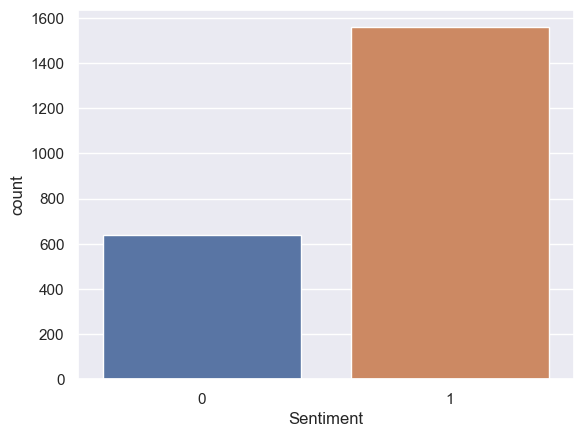

In [9]:
# Plot of variance in Sentiment column, checking for imbalance

sb.countplot(x="Sentiment",data=dataframe)
# dataframe['Sentiment'].value_counts().plot.bar(figsize = (6, 4))

In [10]:
labels=['Positive', 'Negative']

pos_or_neg = dataframe['Sentiment'].value_counts().tolist()
values = [pos_or_neg[0], pos_or_neg[1]]

fig = px.pie(values=dataframe['Sentiment'].value_counts(), 
             names=labels , width=600, height=500, 
             color_discrete_sequence=['blue', 'orange'],
             title="Imbalance between positive and negative sentiments")
fig.show()

There is clearly an imbalance in the Sentiment column, which will be taken care of by introducing $\text{stratify}=y$ in the train_test_split function.

In [11]:
# Modular function for preprocessing the tweets.

ps = PorterStemmer()
lm = WordNetLemmatizer()
# tweet = [ps.stem(word) for word in tweet]
# tweet = [lm.lemmatize(word) for word in tweet]

def tweets_cleaner(tweet):
    """Function to preprocess the tweets for the models

    Returns:
        tweet without stop words, special characters, RT, numbers,
        with stemming applied
    """
    # removing the urls from the text
    tweet = re.sub(r'https?://\S+', r'', tweet)
    tweet = re.sub(r'www.\S+', r'', tweet)
    # removing the numbers from the text
    tweet = re.sub(r'[0-9]\S+', r'', tweet)
    # removing the tags from the text
    tweet = re.sub(r'(@\S+) | (#\S+)', r'', tweet)
    # removing the RT from the text
    tweet = re.sub(r'\bRT\b', r'', tweet)
    # removing repeated characters
    tweet = re.sub(r'(.)1+', r'1', tweet)
    # applying tokenization
    tweet = re.split('\W+', tweet)
    # applying lemmatization
    tweet = [lm.lemmatize(word) for word in tweet]
    # removing the punctuation from the text
    tweet_without_punctuation = [char for char in tweet if char not   
                                in string.punctuation]
    # converting the list to string 
    tweet_without_punctuation = " ".join(tweet_without_punctuation) 
    # set of stop words 
    stop_words = set(stopwords.words("english"))
    # removing the stop words 
    tweet_without_stopwords = [word for word in  
                              tweet_without_punctuation.split()
                              if word.lower() not in stop_words]
    return " ".join(tweet_without_stopwords)

dataframe['Cleaned_Text'] = dataframe['Text'].apply(lambda x: tweets_cleaner(x))
dataframe

,Text,Sentiment,Cleaned_Text
0,gonna make a peach acc too :),1,gonna make peach acc
1,@Diceman27 @Streamboosts Dropped you a follow ...,1,Dropped follow Twitch
2,@sakura_addicted But that was today @ midnight...,0,wa today midnight still
3,RT @brokenworld05: Promotion Time ⏳ Mention ...,1,Promotion Time Mention Ids Promote Note First ...
4,marnie gave me the pouch from her forgotten wo...,1,marnie gave pouch forgotten world pre order cl...
...,...,...,...
3892,RT @Mona_sayss: One sided love kills :(,0,One sided love kill
3894,@VirginiaGal2021 Halo! you can read it here: h...,1,Halo read Enjoy
3895,RT @lpcynl: @bwnyapa Wow :) Thankyou 💙,1,Wow Thankyou
3898,@official_hoony_ AWWWW :( I LOVE U FOUR,0,AWWWW LOVE U FOUR


In [12]:
# Calculating each tweet's length and word count

dataframe['Text_Length'] = dataframe['Text'].astype(str).apply(len)
dataframe['Text_Word_Count'] = dataframe['Text'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(dataframe.groupby('Sentiment').Text_Length.mean()), 2)

,Text_Length
Sentiment,
0,68.96
1,84.76


In [13]:
round(pd.DataFrame(dataframe.groupby('Sentiment').Text_Word_Count.mean()), 2)

,Text_Word_Count
Sentiment,
0,12.17
1,13.66


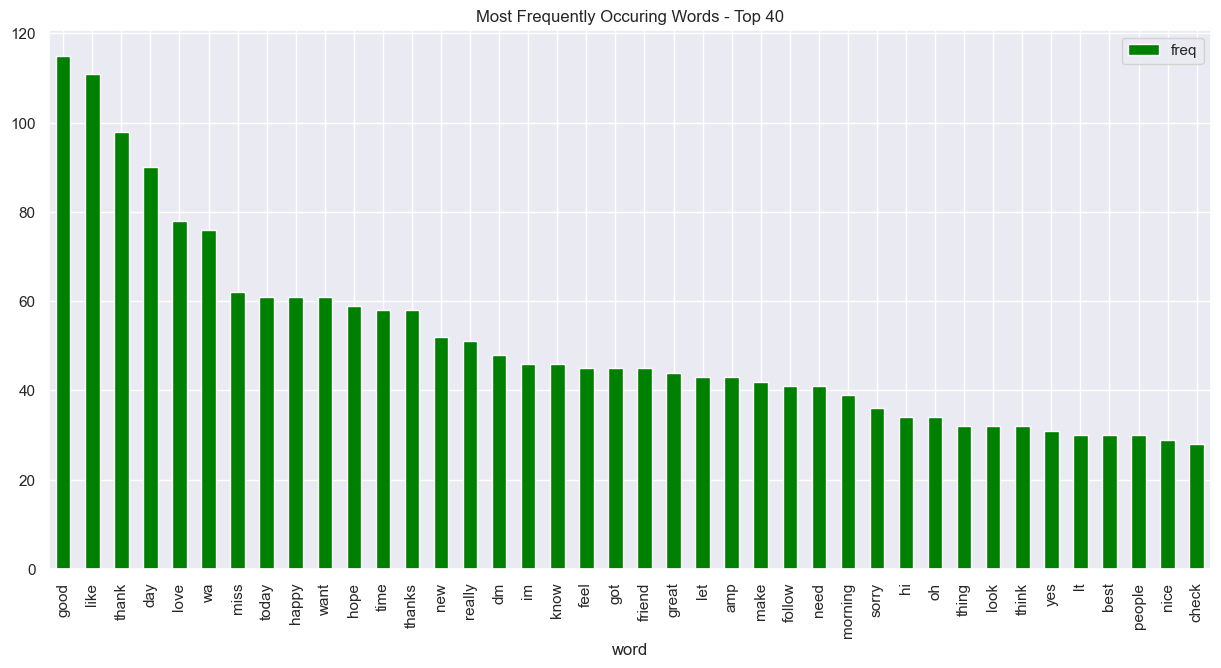

In [14]:
# Plotting the most frequent words used in the tweet dataset

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(dataframe['Cleaned_Text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(40).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color='green')
plt.title("Most Frequently Occuring Words - Top 40")
plt.show()

In [15]:
# Dataframe of most used words

count_vect_df = pd.DataFrame(words.toarray(), columns=cv.get_feature_names_out())
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0, ascending=False).head(-1)
countdf.tail(-10)

,0
hope,59
time,58
thanks,58
new,52
really,51
...,...
hypeee,1
hyper,1
hyungs,1
hyv,1


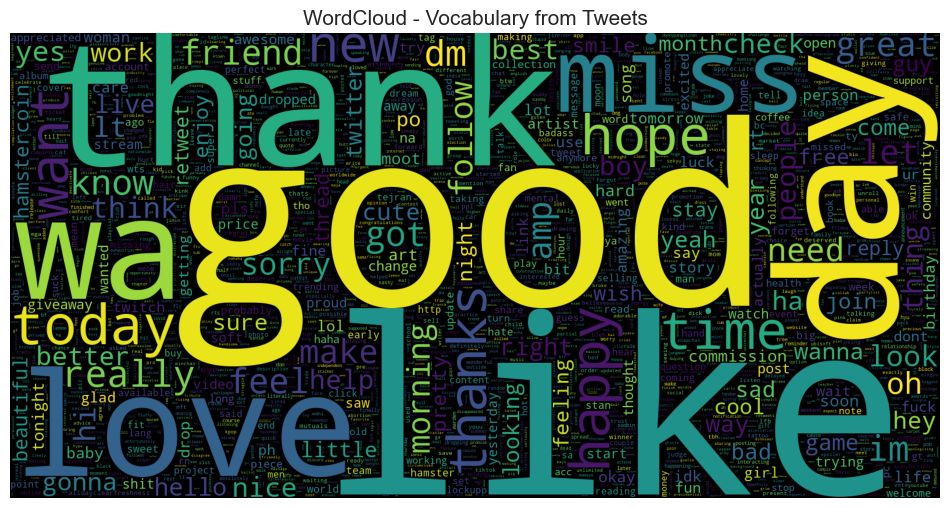

In [16]:
# Word cloud for frequent words used in the tweets

wordcloud = WordCloud(width=1600, 
                      height=800,
                      random_state=0, 
                      max_words=2000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("WordCloud - Vocabulary from Tweets", fontsize=15)
plt.show()

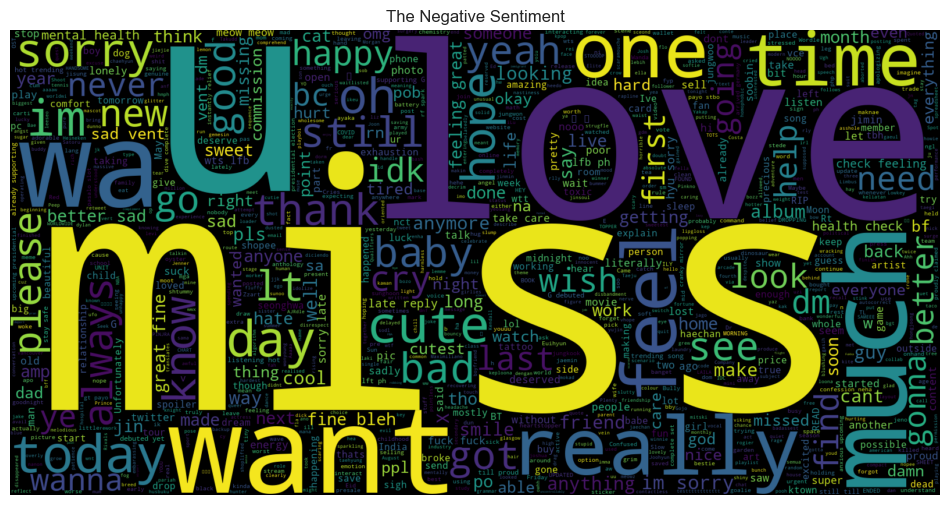

In [17]:
negative_words =' '.join([text for text in dataframe['Cleaned_Text'][dataframe['Sentiment'] == 0]])

wordcloud = WordCloud(width=1600, 
                      height=800, 
                      random_state=0, 
                      max_words=1000).generate(negative_words)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Sentiment')
plt.show()

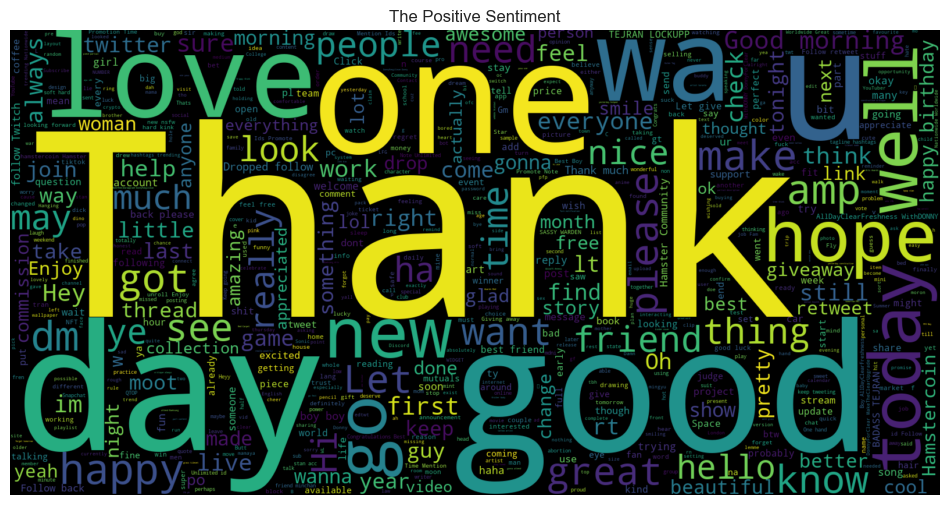

In [18]:
positive_words =' '.join([text for text in dataframe['Cleaned_Text'][dataframe['Sentiment'] == 1]])

wordcloud = WordCloud(width=1600, 
                      height=800, 
                      random_state=0, 
                      max_words=1000).generate(positive_words)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Sentiment')
plt.show()

In [19]:
# Preparing datasets for model

sentences = dataframe['Cleaned_Text']
y = dataframe['Sentiment'].astype(int)

In [20]:
# Train test split, 70% - 30%

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.3, stratify=y, random_state=42)
sentences_train.shape, y_train.shape, sentences_test.shape, y_test.shape

((1537,), (1537,), (660,), (660,))

In [21]:
# Fitting and transforming training dataset to the vectorizer

sentences_train = cv.fit_transform(sentences_train).toarray()
sentences_test = cv.transform(sentences_test).toarray()

In [22]:
type(sentences_train), type(sentences_test), type(y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [23]:
def eval_model(model):
    """
    helper function for displaying classification report and plotting confusion matrix

    Args:
        machine learning model 
    """
    # Predict values for Test dataset
    y_pred = model.predict(sentences_test)
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(cf_matrix, annot=labels, cmap='YlOrRd', fmt='', xticklabels=categories, yticklabels=categories) # YlOrRd YlGnBu YlGn RdPu PuOr BrBG PRGn BuPu PiYG
    plt.xlabel('Predicted values', fontdict ={'size': 14}, labelpad=10)
    plt.ylabel('Actual values' , fontdict ={'size': 14}, labelpad=10)
    plt.title ('Confusion Matrix', fontdict={'size': 18}, pad=20)

To ensure optimal model performance, different ML models will be trained and their evaluation metrics will be compared. The hyperparameters of the preferred model will then be optimized using GridSearchCV algorithm.

In [79]:
# Multinomial Naive-Bayes classifier

mnb = MultinomialNB()
mnb.fit(sentences_train, y_train)

print("Training Accuracy:", mnb.score(sentences_train, y_train))
print("Testing Accuracy:", mnb.score(sentences_test, y_test))

Training Accuracy: 0.9258295380611581
Testing Accuracy: 0.7636363636363637


In [80]:
y_pred = mnb.predict(sentences_test)
confusion_matrix(y_test, y_pred)

array([[ 78, 114],
       [ 42, 426]], dtype=int64)

              precision    recall  f1-score   support

           0       0.65      0.41      0.50       192
           1       0.79      0.91      0.85       468

    accuracy                           0.76       660
   macro avg       0.72      0.66      0.67       660
weighted avg       0.75      0.76      0.74       660



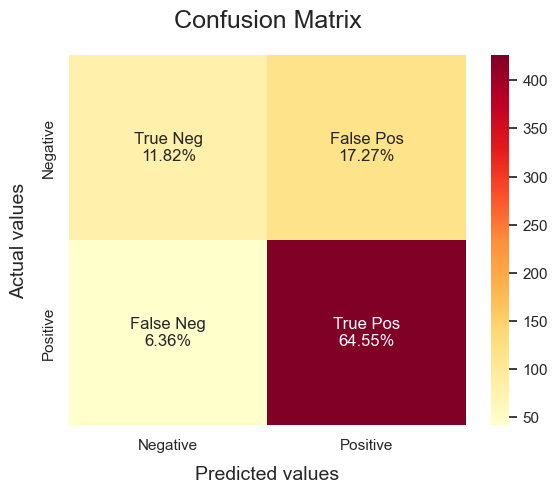

In [25]:
# Calling helper function, eval_model

eval_model(mnb)

In [26]:
# Bernoulli Naive-Bayes classifier

bnb = BernoulliNB()
bnb.fit(sentences_train, y_train)

print("Training Accuracy:", bnb.score(sentences_train, y_train))
print("Testing Accuracy:", bnb.score(sentences_test, y_test))

Training Accuracy: 0.8308392973324659
Testing Accuracy: 0.7348484848484849


              precision    recall  f1-score   support

           0       0.76      0.13      0.22       192
           1       0.73      0.98      0.84       468

    accuracy                           0.73       660
   macro avg       0.75      0.56      0.53       660
weighted avg       0.74      0.73      0.66       660



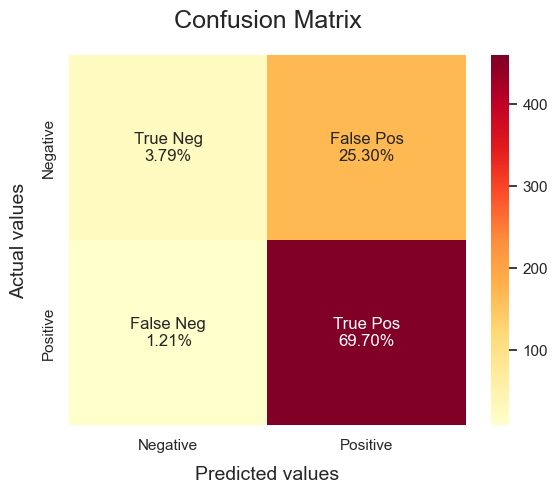

In [27]:
eval_model(bnb)

In [28]:
# Logistic Regression classifier

lr = LogisticRegression()
lr.fit(sentences_train, y_train)

print("Training Accuracy:", lr.score(sentences_train, y_train))
print("Testing Accuracy:", lr.score(sentences_test, y_test))

Training Accuracy: 0.9245283018867925
Testing Accuracy: 0.7651515151515151


              precision    recall  f1-score   support

           0       0.69      0.35      0.46       192
           1       0.78      0.94      0.85       468

    accuracy                           0.77       660
   macro avg       0.73      0.64      0.66       660
weighted avg       0.75      0.77      0.74       660



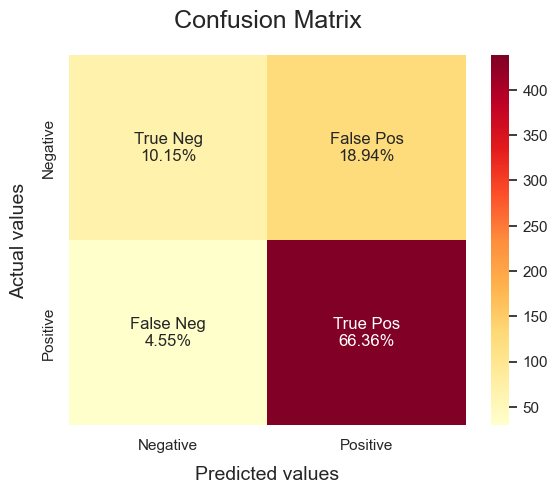

In [29]:
eval_model(lr)

In [30]:
# Support Vector Classifier

svc = SVC(probability=True)
svc.fit(sentences_train, y_train)

print("Training Accuracy:", svc.score(sentences_train, y_train))
print("Testing Accuracy:", svc.score(sentences_test, y_test))

Training Accuracy: 0.8959011060507482
Testing Accuracy: 0.7606060606060606


              precision    recall  f1-score   support

           0       0.83      0.22      0.35       192
           1       0.75      0.98      0.85       468

    accuracy                           0.76       660
   macro avg       0.79      0.60      0.60       660
weighted avg       0.78      0.76      0.71       660



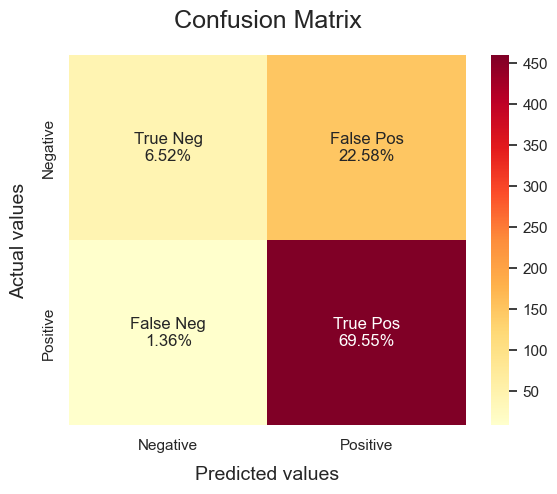

In [31]:
eval_model(svc)

In [32]:
# Decision Tree Classifier

dtc = DecisionTreeClassifier()
dtc.fit(sentences_train, y_train)

print("Training Accuracy:", dtc.score(sentences_train, y_train))
print("Testing Accuracy:", dtc.score(sentences_test, y_test))

Training Accuracy: 0.9869876382563435
Testing Accuracy: 0.7363636363636363


              precision    recall  f1-score   support

           0       0.55      0.54      0.54       192
           1       0.81      0.82      0.81       468

    accuracy                           0.74       660
   macro avg       0.68      0.68      0.68       660
weighted avg       0.74      0.74      0.74       660



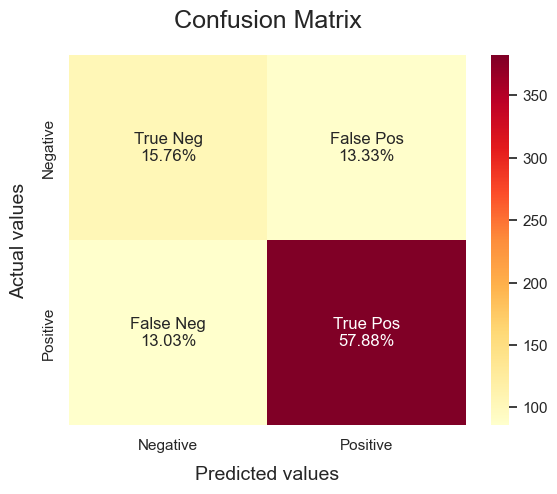

In [33]:
eval_model(dtc)

In [34]:
# Random Forest Classifier

rfc = RandomForestClassifier()
rfc.fit(sentences_train, y_train)

print("Training Accuracy:", rfc.score(sentences_train, y_train))
print("Testing Accuracy:", rfc.score(sentences_test, y_test))

Training Accuracy: 0.9869876382563435
Testing Accuracy: 0.7651515151515151


              precision    recall  f1-score   support

           0       0.63      0.48      0.54       192
           1       0.81      0.88      0.84       468

    accuracy                           0.77       660
   macro avg       0.72      0.68      0.69       660
weighted avg       0.75      0.77      0.75       660



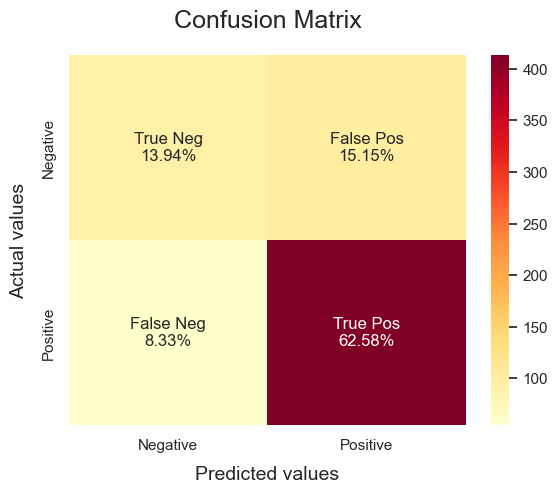

In [35]:
eval_model(rfc)

### Analysis of results
Since we are dealing with an imbalanced target, the accuracy metric will not be used to evaluate the model's performance. We will rather use Precision (how many positive predictions are actually true positives)
\begin{equation}
\text{Precision} = \frac{\text{True positives}}{\text{True positives}+\text{False positives}}
\end{equation}
and 
recall (what percentage of true positives did we actually get right)
\begin{equation}
\text{Recall} = \frac{\text{True positives}}{\text{True positives}+\text{False negatives}}
\end{equation}
We will also use the F1-score
\begin{equation}
\text{F1-score} = \frac{2\times\text{Precision}\times\text{Recall}}{\text{Precision}+\text{Recall}}
\end{equation}
to evaluate model performance. The Random Forest Classifier seems to outperform all the other models using these three performance metrics. It had the highest F1-score for the negative sentiment. Despite that, the Decision Tree Classifier has an edge that it seems to be unbiased and quite balanced between it's precision and recall scores for both positive and negative sentiments.

The Multinomial Naive-Bayes, Bernoulli Naive-Bayes, Logisitic Regression, Support Vector Classifier all seems to accurately predict the positive sentiment with higher accuracy than the Random Forest and Decision Tree models, they have a high tendency of predicting positives most of the times (the imbalance between positive and negative sentiment is quite dominant).

> Between the Random Forest and Decision Tree, it seems to be that the Decision Tree model probably guesses correct positive sentiment (True Pos of 57%) compared to the Random Forest (True Pos of 63%). The Random Forest algorithm also has a higher chance of being correct for every negative sentiment compared to the Decision Tree. The Logistic Regression came quite close to the Random Forest model but the Random Forest will still be preferred because it a higher Recall for the negative sentiment.

**Core Observation**: All the models except the Logistic Regression were overfitting to the training data. The hyperparameter optimization will hopefully solve this. 

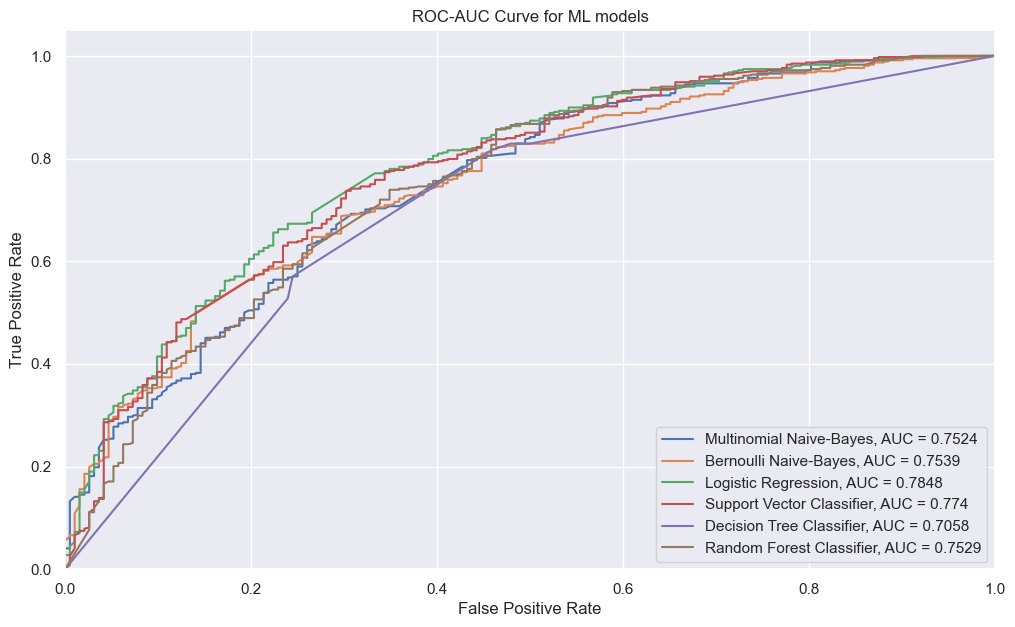

In [36]:
# Setting up plotting area

plt.figure(0, figsize=(12, 7)).clf()

# ROC-AUC curve for MultinomialNB
y_pred_mnb = mnb.predict_proba(sentences_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_mnb)
auc = round(roc_auc_score(y_test, y_pred_mnb), 4)
plt.plot(fpr, tpr, label="Multinomial Naive-Bayes, AUC = "+str(auc))

# ROC-AUC curve for BernoulliNB
y_pred_bnb = bnb.predict_proba(sentences_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_bnb)
auc = round(roc_auc_score(y_test, y_pred_bnb), 4)
plt.plot(fpr, tpr, label="Bernoulli Naive-Bayes, AUC = "+str(auc))

# ROC-AUC curve for Logistic Regression
y_pred_lr = lr.predict_proba(sentences_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
auc = round(roc_auc_score(y_test, y_pred_lr), 4)
plt.plot(fpr, tpr, label="Logistic Regression, AUC = "+str(auc))

# ROC-AUC curve for Support Vector Classifier
y_pred_svc = svc.predict_proba(sentences_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_svc)
auc = round(roc_auc_score(y_test, y_pred_svc), 4)
plt.plot(fpr, tpr, label="Support Vector Classifier, AUC = "+str(auc))

# ROC-AUC curve for Decision Tree Classifier
y_pred_dtc = dtc.predict_proba(sentences_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_dtc)
auc = round(roc_auc_score(y_test, y_pred_dtc), 4)
plt.plot(fpr, tpr, label="Decision Tree Classifier, AUC = "+str(auc))
 
# ROC-AUC curve for Random Forest Classifier
y_pred_rfc = rfc.predict_proba(sentences_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_rfc)
auc = round(roc_auc_score(y_test, y_pred_rfc), 4)
plt.plot(fpr,tpr,label="Random Forest Classifier, AUC = "+str(auc))

# Add legend and label
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for ML models')
plt.legend()
plt.show()

### Preferred Model
To decide on the preferred model, the combined ROC-AUC curves will be used. The Logistic Regression clearly has a higher AUC score compared to other models. From the previous analysis and the results obtained from this combined ROC-AUC curves, the Logistic Regression model will be the preferred model because it has a higher AUC score.

In [61]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=False)

score = cross_val_score(lr, sentences_train, y_train, cv=kf, scoring='accuracy')
print("Cross Validation Accuracy scores are: {}".format(score))
print("Average Cross Validation Accuracy score: {}".format(score.mean()))

Cross Validation Accuracy scores are: [0.77272727 0.77272727 0.74675325 0.78571429 0.75974026 0.75324675
 0.76623377 0.77777778 0.77777778 0.78431373]
Average Cross Validation Accuracy score: 0.7697012138188608


In [69]:
grid_params = {
  'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 7, 10],
  'penalty': ['l1', 'l2'],
  'solver': ['liblinear', 'saga']
}

# Perform grid search for LogisticRegression
gs_clf = GridSearchCV(lr, 
                      grid_params, 
                      n_jobs=-1,
                      refit=True,
                      cv=kf,
                      scoring='accuracy',
                      verbose=2)

gs_clf.fit(sentences_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\Victor Jr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 5, 7, 10],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [70]:
results = pd.DataFrame(gs_clf.cv_results_)

results.loc[gs_clf.best_index_,:]
# results[results['rank_test_score'] == 1]

mean_fit_time                                          10.574489
std_fit_time                                            0.790925
mean_score_time                                         0.004701
std_score_time                                          0.001345
param_C                                                        7
param_penalty                                                 l2
param_solver                                                saga
params               {'C': 7, 'penalty': 'l2', 'solver': 'saga'}
split0_test_score                                       0.772727
split1_test_score                                       0.779221
split2_test_score                                        0.74026
split3_test_score                                       0.785714
split4_test_score                                       0.772727
split5_test_score                                       0.766234
split6_test_score                                       0.766234
split7_test_score        

In [71]:
gs_clf.best_estimator_

LogisticRegression(C=7, solver='saga')

In [72]:
gs_clf.best_score_

0.7742594007299889

In [73]:
y_pred = gs_clf.predict(sentences_test)

              precision    recall  f1-score   support

           0       0.69      0.40      0.51       192
           1       0.79      0.93      0.85       468

    accuracy                           0.77       660
   macro avg       0.74      0.66      0.68       660
weighted avg       0.76      0.77      0.75       660



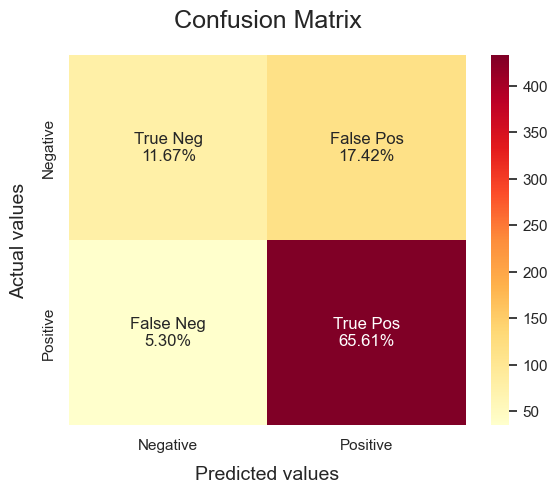

In [74]:
eval_model(gs_clf)

In [85]:
sample_tweet_1 = ['This is me, I am so excited... Yaaaaa']
sample_tweet_2 = ['So sad, not fair... What have I done? Just sad #crying']

In [86]:
tweet_1 = cv.transform(sample_tweet_1)
tweet_2 = cv.transform(sample_tweet_2)

In [87]:
predicted_sentiment = gs_clf.predict_proba(tweet_1)
predicted_sentiment = ['Positive Sentiment' if proba[1] >= 0.5 else 'Negative Sentiment' for proba in predicted_sentiment]

# Join the list of sentiments into a single string
predicted_sentiment = ', '.join(predicted_sentiment)
predicted_sentiment

'Positive Sentiment'

In [88]:
predicted_sentiment = gs_clf.predict_proba(tweet_2)
predicted_sentiment = ['Positive Sentiment' if proba[1] >= 0.5 else 'Negative Sentiment' for proba in predicted_sentiment]

# Join the list of sentiments into a single string
predicted_sentiment = ', '.join(predicted_sentiment)
predicted_sentiment

'Negative Sentiment'

In [90]:
# Saving the vectorizer and the trained model to disk, for deployment purposes

pickle.dump(cv, open('outputs/vectorizer.sav', 'wb'))

filename = 'outputs/final_model.sav'
pickle.dump(gs_clf, open(filename, 'wb'))